In [1]:
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import Featurizer as ft

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Importo dataset

In [2]:
df = pd.read_csv('../data/features.csv')
df_test = pd.read_csv('../data/test_features.csv')

In [3]:
x = df[df.columns.drop("precio")]
y = df['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

#x_train, x_test, y_train = x, df_test, y

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 44) y=(240000,)
Train shapes: X=(192000, 44) y=(192000,)
Test  shapes: X=(48000, 44)  y=(48000,)


 ## Completo los datos faltantes

In [4]:
x_train = ft.main(x_train)

--- 61.1637225151062 seconds ---


In [5]:
x_test = ft.main(x_test)

--- 14.937434196472168 seconds ---


In [6]:
oneHot = ['tipodepropiedad','provincia']
binary = ['ciudad','ciudad-provincia']
all_cats = ['tipodepropiedad','provincia','ciudad','ciudad-provincia']

 ## Encode


In [7]:
x_train = ft.OHE(x_train,oneHot)
x_test = ft.OHE(x_test,oneHot)

x_train = ft.binary(x_train,binary)
x_test = ft.binary(x_test,binary)

In [8]:
df_ids = x_test["id"]
x_train = x_train.drop(columns=["id"])
x_test = x_test.drop(columns=["id"])

In [9]:
for a in x_train.columns[~x_train.columns.isin(x_test.columns)]:
    x_test[a] = 0

print(x_test.shape[1] == x_train.shape[1])

print(f"Train shapes: X={x_train.shape} y={x_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={x_test.shape}")

True
Train shapes: X=(192000, 172) y=(192000, 172)
Test  shapes: X=(48000, 172)  y=(48000, 172)



## Modelo y entreno

In [10]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=400,max_depth=10,n_jobs=-1,objective="reg:squarederror")

In [11]:
model.fit(x_train, y_train)

/home/peter/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

## Predicciones

In [12]:
x_test = x_test[x_train.columns]

In [13]:
ft.predecir(model,x_train,y_train,x_test,y_test)

Entrenamiento: 95.3520%
Testeo: 44.7634%.
Mean abs error: 992025.6963.


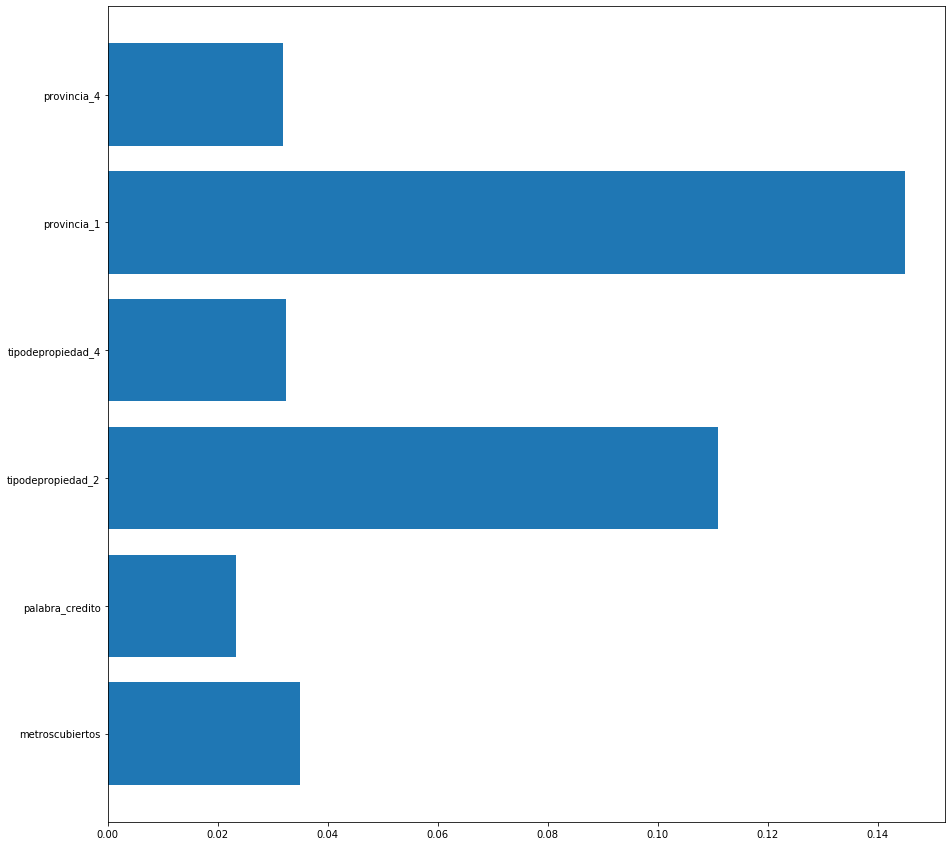

In [14]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':x_train.columns,'y':importancia}

importancia = pd.DataFrame(d)
importancia = importancia[importancia.y>0.02]
ax = plt.barh(importancia.x,importancia.y)

In [29]:
#Predigo los precios
predict = model.predict(data_test)

In [30]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")

In [31]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")
result.to_csv("../data/results/resultRF_Features.csv", index=False)

In [13]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_depth = [5,10,15, None]
num_leaves = [5,10,15, 31, 50]
min_child_samples = [10, 30, 50, 20]
min_child_weight = [0.1,1,0.0001]



random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
               'min_child_samples': min_child_samples,
               'min_child_weight': min_child_weight
              }

In [15]:
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV

model = lgb.LGBMRegressor()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, 
                               n_iter = 25,
                               n_jobs = -1,
                               verbose=2)

random_search.fit(data_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/home/peter/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 13.5min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0...
                                           subsample_freq=0),
                   iid='warn', n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, N

In [16]:
rf_random = random_search.best_estimator_

In [17]:
rf_random

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=None,
              min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
              n_estimators=944, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)